<a href="https://colab.research.google.com/github/julycapstone2020/Pneumonia-Detection-Challenge/blob/development/notebook/Pneumonia_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Pneumonia Detection 

This notebook build an end-to-end build a pneumonia detection system, to locate the position of inflammation in an image.

Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting `lung opacities`, there are lung opacities that are not pneumonia related.

## 1. Problem

To locate the position of inflammation in an image.

## 2. Data

In the data, some of these are labeled `Not Normal No Lung Opacity`.This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images: -Medical images are stored in a special format called DICOM files `(*.dcm)`. They contain a combination of header metadata as well as underlying raw image arrays for pixel data.Details about the data and dataset files are given in below link,

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

### Pre-Processing, Data Visualization, EDA 

* Exploring the given Data files, classes and images of different classes.
* Dealing with missing values
* Visualizationof different classes 
* Analysis from the visualizationof different classes


### Model Building 

* Building a pneumonia detection model starting from basic CNN and then improving upon it.
* Train the model
* To deal with large training time, save the weights so that you can use them when training the model for the second time without starting from scratch


### Test the Model, Fine-tuning and Repeat

* Test the model and report as per evaluation metrics
* Try different models
* Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc. for these models to fine-tune them
* Report evaluation metrics for these modelsalong with your observation on how changing different hyper parameters leads to change in the final evaluation metric.

## 3. Evaluation



## 4. Features



In [1]:
#! pip install pydicom

In [2]:
 #!unzip "/content/drive/My Drive/Pneumonia Detection/rsna-pneumonia-detection-challenge.zip" -d "drive/My Drive/Pneumonia Detection/"

Get our workspace ready

* Import TensorFlow 2.x 
* Import TensorFlow Hub
* Make sure we're using GPU

In [3]:
# Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("TF version", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version 2.2.0
TF Hub version: 0.8.0
GPU available (YESSSSS!!!!!)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# To save your the installed configuration to your Google Drive
# !pip freeze --local > drive/My\ Drive/Pneumonia\ Detection/requirements.txt

In [6]:
# To restore out installed configuration from the requirement.txt
!pip install --upgrade --force-reinstall `cat drive/My\ Drive/Pneumonia\ Detection/requirements.txt`

  Using cached https://files.pythonhosted.org/packages/d3/56/342e1f8ce5afe63bf65c23d0b2c1cd5a05600caad1c211c39725d3a4cc56/pydicom-2.0.0-py3-none-any.whl
  Found existing installation: pydicom 2.0.0
    Uninstalling pydicom-2.0.0:
      Successfully uninstalled pydicom-2.0.0


## Getting our data ready 

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. (numerical representations).

Let's start by accessing our data and checking out the labels.

In [7]:
# Checkout the labels of our data

PROJECT_DIR = "drive/My Drive/Pneumonia Detection/"

class_info_df = pd.read_csv(PROJECT_DIR + 'stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PROJECT_DIR +'stage_2_train_labels.csv')

print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [8]:
class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [9]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### Create a function to find the missing data in the dataset

In [10]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

In [11]:
# Missing data from train labels dataset
missing_data(train_labels_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [12]:
# Missing data from class dataset
missing_data(class_info_df)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


Lets find out how many are labeled `Not Normal, No Lung Opacity and Normal`.

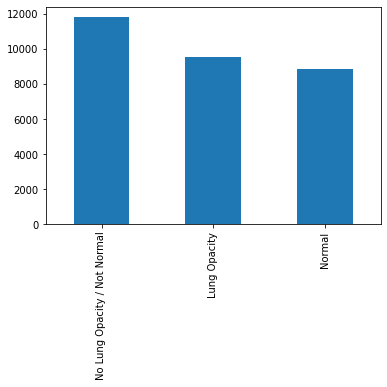

In [13]:
class_info_df['class'].value_counts().plot.bar(figsize=(6,4))

### Merge both `class info` and `train labels` into one dataset

In [14]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [15]:
train_class_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [16]:
train_class_df.dtypes

patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
class         object
dtype: object

### Let's view heat map of the features

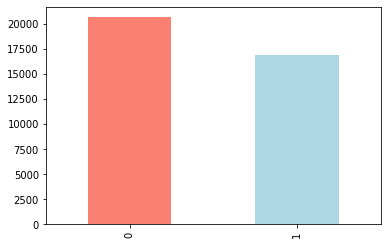

In [17]:
# Plot the value counts with a bar graph
train_class_df['Target'].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

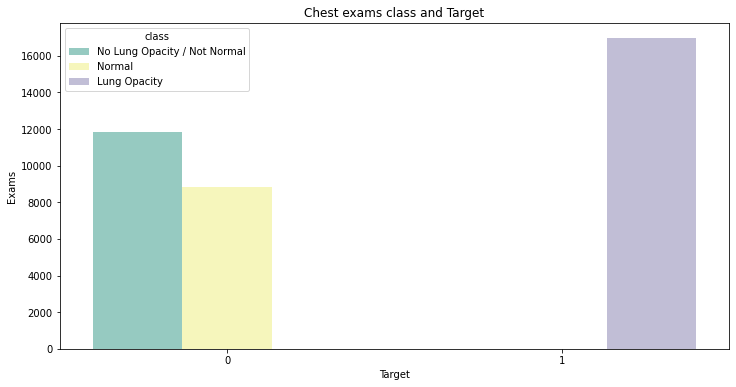

In [18]:

fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

<Figure size 432x288 with 0 Axes>

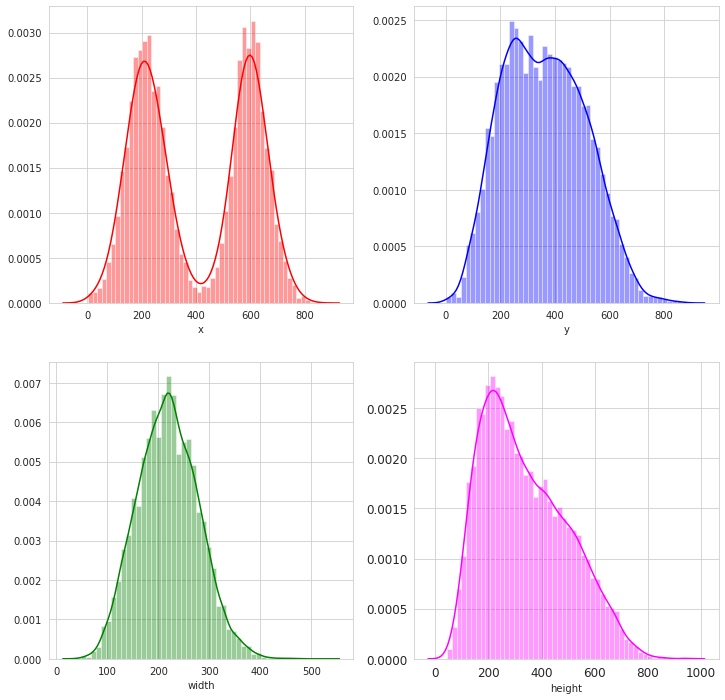

In [19]:
# Check out the distrubution for the target where target is _samples_1
target_samples_1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target_samples_1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target_samples_1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target_samples_1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target_samples_1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

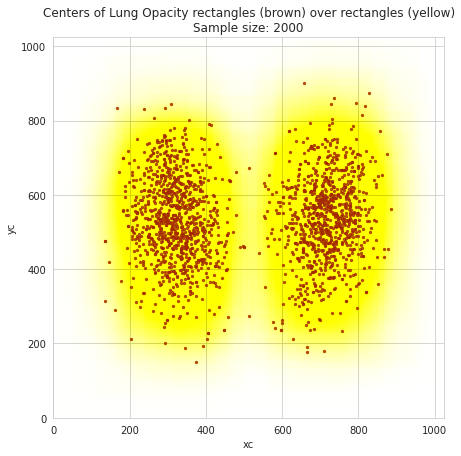

In [20]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1,1,figsize=(7,7))
target_samples_2 = target_samples_1.sample(2000)
target_samples_2['xc'] = target_samples_2['x'] + target_samples_2['width'] / 2
target_samples_2['yc'] = target_samples_2['y'] + target_samples_2['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_samples_2.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_samples_2.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [21]:
import os
image_sample_path = os.listdir(PROJECT_DIR + "stage_2_train_images")[:5]
print(image_sample_path)

['f7d7c75e-5971-4111-be3c-1be97c9d22e0.dcm', 'f770d37d-4f5c-4b0f-afdf-ffb9198a603d.dcm', 'f7197843-6673-4364-a46c-3a783c8540e9.dcm', 'f6e624f8-75fd-4f03-9119-24a617008e2b.dcm', 'f7d0e9c2-68d8-4742-9ce6-1ac3d250cb35.dcm']


In [22]:
image_train_path = os.listdir(PROJECT_DIR +"stage_2_train_images")

image_test_path = os.listdir(PROJECT_DIR +"stage_2_test_images")

print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


In [23]:
print("Unique patientId in  train_class_df: ", train_class_df.patientId.nunique())

Unique patientId in  train_class_df:  26684


### Read DICOM Metadata

In [24]:
## DICOM METADATA
import pydicom as dcm
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID +'.dcm'
dicom_file_path = os.path.join(PROJECT_DIR +"stage_2_train_images/", samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [25]:


def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PROJECT_DIR +"stage_2_train_images/", patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

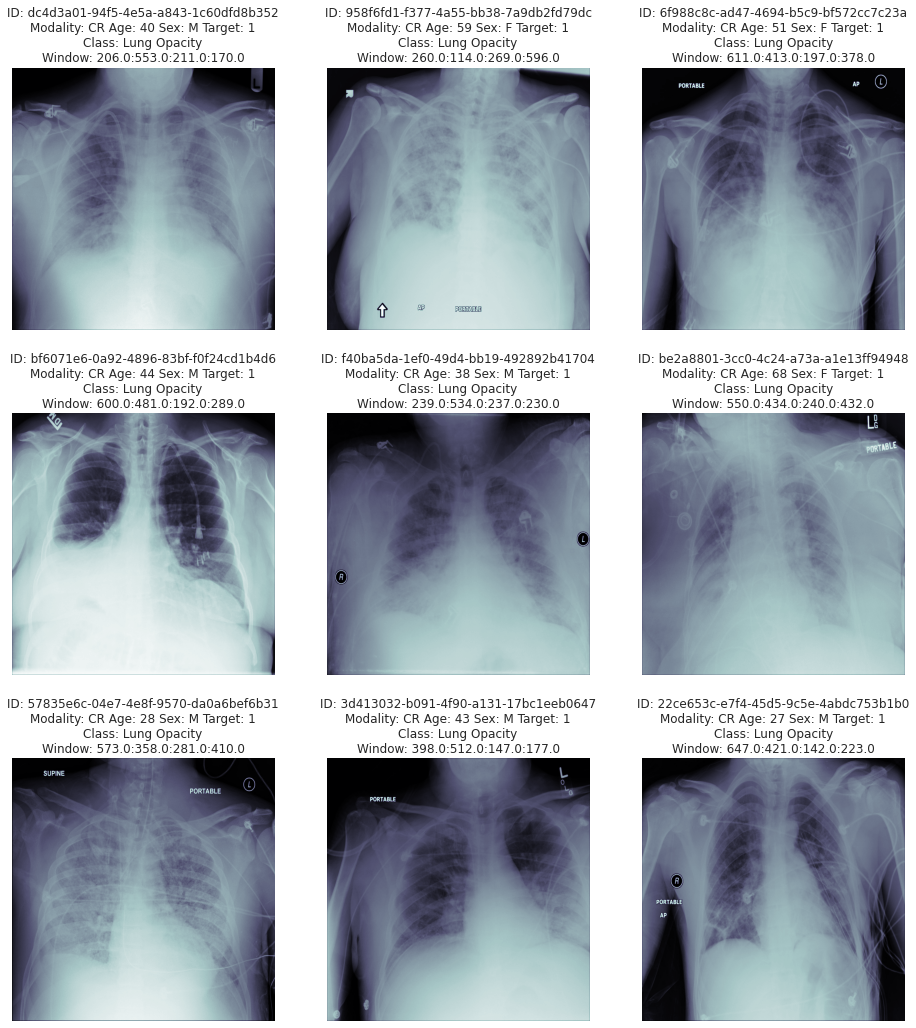

In [26]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

In [27]:
from tqdm.notebook import tqdm
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(data_path)
    for i, img_name in tqdm(enumerate(image_names)):
        #imagePath = os.path.join(img_path,data_path,img_name)
        imagePath = os.path.join(data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0])

In [28]:
# process_dicom_data(train_class_df, PROJECT_DIR +"stage_2_train_images")

In [29]:
#print(train_class_df.columns)

### Load already processed train and test data from excel files

In [127]:
train_df = pd.read_excel(PROJECT_DIR + 'final_train_class_df.xlsx')
test_df = pd.read_excel(PROJECT_DIR +'final_test_class_df.xlsx')

In [128]:
train_df.head()

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,1024,1024,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,1024,1024,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,1024,1024,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,CR,28,M,CHEST,PA,WSD,1024,1024,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,CR,32,F,CHEST,AP,WSD,1024,1024,0.139


In [129]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37629 entries, 0 to 37628
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patientId         37629 non-null  object 
 1   x                 16957 non-null  float64
 2   y                 16957 non-null  float64
 3   width             16957 non-null  float64
 4   height            16957 non-null  float64
 5   Target            37629 non-null  int64  
 6   class             37629 non-null  object 
 7   Modality          37629 non-null  object 
 8   PatientAge        37629 non-null  int64  
 9   PatientSex        37629 non-null  object 
 10  BodyPartExamined  37629 non-null  object 
 11  ViewPosition      37629 non-null  object 
 12  ConversionType    37629 non-null  object 
 13  Rows              37629 non-null  int64  
 14  Columns           37629 non-null  int64  
 15  PixelSpacing      37629 non-null  float64
dtypes: float64(5), int64(4), object(7)
memor

In [130]:
test_df.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


## Fill missing values 

### Fill numerical missing values first

In [131]:
for label, content in train_df.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

x
y
width
height
Target
PatientAge
Rows
Columns
PixelSpacing


In [132]:
# Check for which numeric columns have null value
for label, content in train_df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

x
y
width
height


In [133]:
# Fill numeric rows with the zero
for label, content in train_df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            train_df[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            train_df[label] = content.fillna(0)

In [134]:
train_df.Rows.fillna(0, inplace=True)
train_df.Columns.fillna(0, inplace=True)

In [135]:
# Check if there are any missing numberic values
train_df.isna().sum()

patientId            0
x                    0
y                    0
width                0
height               0
Target               0
class                0
Modality             0
PatientAge           0
PatientSex           0
BodyPartExamined     0
ViewPosition         0
ConversionType       0
Rows                 0
Columns              0
PixelSpacing         0
x_is_missing         0
y_is_missing         0
width_is_missing     0
height_is_missing    0
dtype: int64

In [136]:
# Check first 5 datapoints
train_df.head()

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,x_is_missing,y_is_missing,width_is_missing,height_is_missing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,True,True,True,True
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,True,True,True,True
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,True,True,True,True
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,True,True,True,True
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,CR,32,F,CHEST,AP,WSD,1024,1024,0.139,False,False,False,False


### Filling and turning categorical variables into numbers

In [137]:
# Check for columns which aren't numeric
for label, content in train_df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

patientId
class
Modality
PatientSex
BodyPartExamined
ViewPosition
ConversionType


In [138]:
# Check for which non numeric columns have null value
for label, content in train_df.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [139]:
pd.Categorical(train_df["class"])

[No Lung Opacity / Not Normal, No Lung Opacity / Not Normal, No Lung Opacity / Not Normal, Normal, Lung Opacity, ..., Normal, Lung Opacity, Lung Opacity, Lung Opacity, Lung Opacity]
Length: 37629
Categories (3, object): [Lung Opacity, No Lung Opacity / Not Normal, Normal]

In [140]:
# Find the unique patient ids
len(train_df.patientId.unique())

26684

### Pneumonia Frequency according to sex

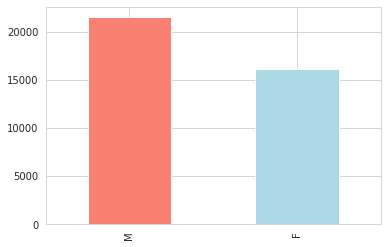

In [141]:
# Plot the value counts with a bar graph
train_df['PatientSex'].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

In [142]:
# Compare target column with sex column
pd.crosstab(train_df.Target, train_df.PatientSex)

PatientSex,F,M
Target,,
0,9016,11656
1,7115,9842


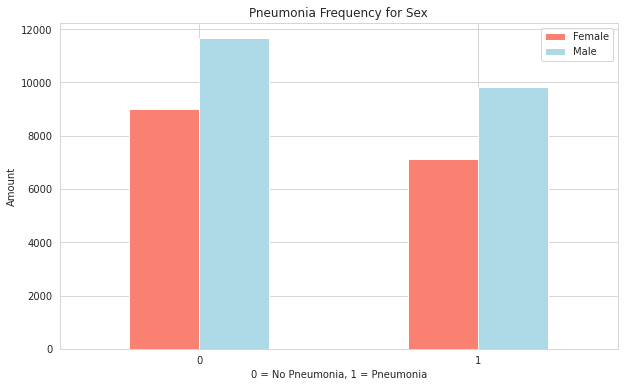

In [143]:
# Create a plot
pd.crosstab(train_df.Target, train_df.PatientSex).plot(kind="bar",
                                    figsize=(10,6),
                                    color=["salmon", "lightblue"]
                            );
plt.title("Pneumonia Frequency for Sex")
plt.xlabel("0 = No Pneumonia, 1 = Pneumonia")
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

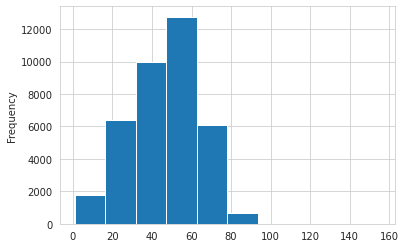

In [144]:
train_df['PatientAge'].plot.hist()

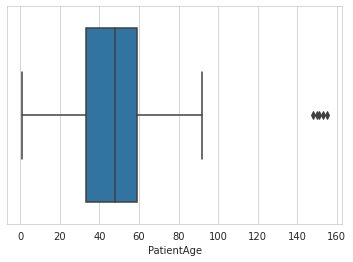

In [145]:
sns.boxplot(x=train_df['PatientAge'], data=train_df)

Correlation between independent variables
We'll compare all of the independent variables in one hit.

This may give an idea of which independant variables may or may not have an impact on target

In [146]:
# Make a correlation matrix

train_df.corr()

,x,y,width,height,Target,PatientAge,Rows,Columns,PixelSpacing,x_is_missing,y_is_missing,width_is_missing,height_is_missing
x,1.000000,0.723681,0.758832,0.691550,0.822018,-0.055643,NaN,NaN,0.087181,-0.822018,-0.822018,-0.822018,-0.822018
y,0.723681,1.000000,0.770833,0.569283,0.873077,-0.021077,NaN,NaN,0.085483,-0.873077,-0.873077,-0.873077,-0.873077
width,0.758832,0.770833,1.000000,0.904337,0.939615,-0.052846,NaN,NaN,0.102228,-0.939615,-0.939615,-0.939615,-0.939615
height,0.691550,0.569283,0.904337,1.000000,0.844190,-0.055932,NaN,NaN,0.103853,-0.844190,-0.844190,-0.844190,-0.844190
Target,0.822018,0.873077,0.939615,0.844190,1.000000,-0.062877,NaN,NaN,0.102015,-1.000000,-1.000000,-1.000000,-1.000000
PatientAge,-0.055643,-0.021077,-0.052846,-0.055932,-0.062877,1.000000,NaN,NaN,0.015226,0.062877,0.062877,0.062877,0.062877
Rows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Columns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PixelSpacing,0.087181,0.085483,0.102228,0.103853,0.102015,0.015226,NaN,NaN,1.000000,-0.102015,-0.102015,-0.102015,-0.102015
x_is_missing,-0.822018,-0.873077,-0.939615,-0.844190,-1.000000,0.062877,NaN,NaN,-0.102015,1.000000,1.000000,1.000000,1.000000


(13.5, -0.5)

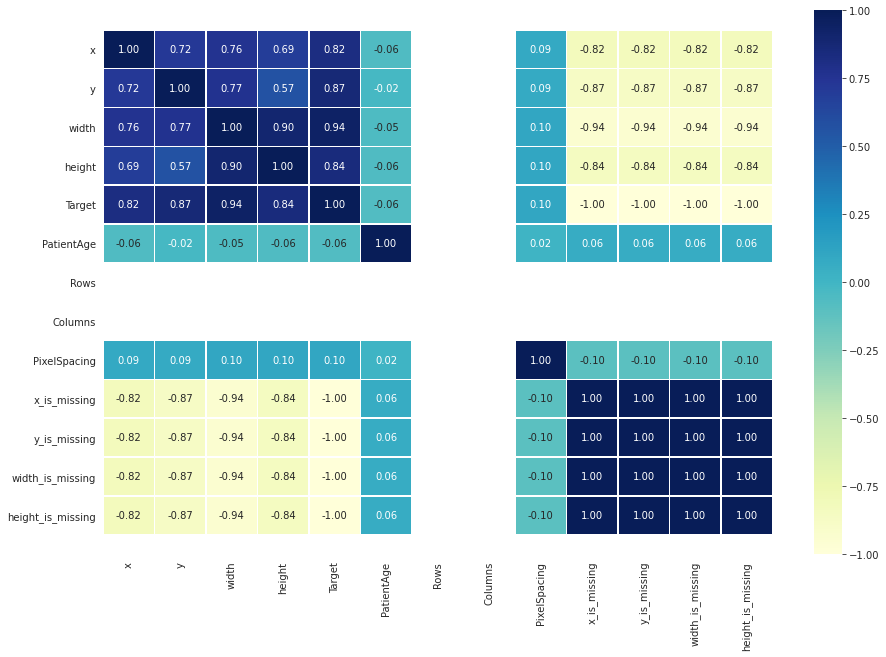

In [147]:
# Let's make our correlation matrix a little prettier
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu");
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [148]:
train_df.drop_duplicates(subset=['patientId', 'x', 'y', 'width', 'height' ], keep=False, inplace=True)

train_df.head()

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,x_is_missing,y_is_missing,width_is_missing,height_is_missing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,True,True,True,True
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,True,True,True,True
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,True,True,True,True
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,True,True,True,True
8,00569f44-917d-4c86-a842-81832af98c30,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,54,M,CHEST,AP,WSD,1024,1024,0.139,True,True,True,True


In [149]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23286 entries, 0 to 37624
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientId          23286 non-null  object 
 1   x                  23286 non-null  float64
 2   y                  23286 non-null  float64
 3   width              23286 non-null  float64
 4   height             23286 non-null  float64
 5   Target             23286 non-null  int64  
 6   class              23286 non-null  object 
 7   Modality           23286 non-null  object 
 8   PatientAge         23286 non-null  int64  
 9   PatientSex         23286 non-null  object 
 10  BodyPartExamined   23286 non-null  object 
 11  ViewPosition       23286 non-null  object 
 12  ConversionType     23286 non-null  object 
 13  Rows               23286 non-null  int64  
 14  Columns            23286 non-null  int64  
 15  PixelSpacing       23286 non-null  float64
 16  x_is_missing       232

We're going to start off experimenting with ~1000 images and increase as needed.

In [150]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}